#### Task Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install mlxtend --quiet

from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample


Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv('../data/diabetes_cleaned.csv')
print(df.columns.tolist())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


Prepare the dataset by applying an appropriate normalization method to the variables. <br>
Should you normalize the outcome variable? <br>
Should you use the same method for all variables or decide for each variable individually?

##### Answer:
No, the outcome variable should not be normalized. The outcome variable is  a categorical variable (e.g., 0 or 1 for binary classification) and normalization is not applicable to categorical data. Normalization is used for continuous variables to bring them to a common scale.


It is generally a good practice to use the same normalization method for all continuous variables to maintain consistency. However, if certain variables have very different distributions, it might be make sense to consider different normalization methods for those specific variables.

e.g.
- z-score for normally distributed var
- min-max for slightly skewed
- log transformation for highly skewed

In [12]:
from sklearn.preprocessing import StandardScaler

# List of continuous variables to normalize (excluding 'Pregnancies')
continuous_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the continuous variables
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

# Display the first few rows of the normalized dataframe
print(df.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.634746  0.883160      -0.037977       0.571282  0.451398  0.179581   
1    -0.849868 -1.200959      -0.519865      -0.014217 -0.734513 -0.841602   
2     1.228591  2.041003      -0.680494       0.864032 -0.853104 -1.323017   
3    -0.849868 -1.068634      -0.519865      -0.599717 -0.531214 -0.622777   
4     0.337823 -0.175440       0.122653       0.864032  0.366690 -0.987485   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.645177  1.423761        1  
1                 -0.351147 -0.190645        0  
2                  0.807621 -0.105676        1  
3                 -1.015363 -1.040333        0  
4                 -0.892627 -0.275614        0  


#### Task PCA

1) Perform PCA on all input variables.
2) Use a screeplot and the elbow method to decide how many PCs should be included in further analysis. How much variance is explained by the chosen PCs?
3) Interprete the eigenvectors/loadings of the 2 PCs with the highest eigenvalue. Use a visualization method for explanation.
4) Split the dataset by "Outcome". Perform PCA for both subsets. Are there clearly visible differences in the PCs? What does that mean?

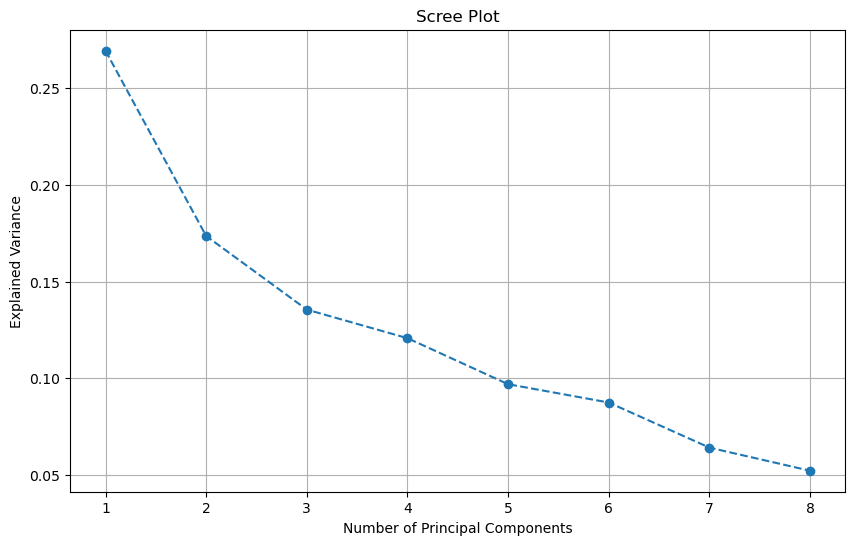

Number of Principal Components to include: 5


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# List of input variables (excluding 'Outcome')
input_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Standardize the input variables
scaler = StandardScaler()
df[input_vars] = scaler.fit_transform(df[input_vars])

# Perform PCA
pca = PCA()
pca.fit(df[input_vars])

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Determine the number of PCs to include using the elbow method
num_pcs = np.argmax(np.diff(explained_variance) < 0) + 1  # Choose PCs based on the elbow dip

# Determine the number of PCs to include using the elbow method
# cumulative_variance = np.cumsum(explained_variance)
# num_pcs = np.argmax(cumulative_variance >= 0.95) + 1  # Choose PCs that explain at least 95% of the variance

# print(f'Number of Principal Components to include: {num_pcs}')
# print(f'Variance explained by the chosen PCs: {cumulative_variance[num_pcs-1]:.2f}')

num_pcs = 5
print(f'Number of Principal Components to include: {num_pcs}')

##### Scaling:
Scaling is to have the same ranges of different attributes while keeping the their original variances.
- Z-scaling/Standard-Scaler (for Gaussian distribution)
- Min-Max-scaling
- Log  (normal distrbution)
BUT:
Use the same scaler for all variables so that they don't cause problem for PCA, since mixed approached could still results to different range.
#####  Alternative approach
- First transform the features so that it's simmilar to gaussian distribution
- then run the z-scaler
- but tricky and labour intensive.

##### NOTE:
When using the elbow method, choose the point before the sharp fall, not after.

##### Scree Plot

You can try to plot both the original variance to determine the elbow point and the cummmulative explained variance on the same diagram for clearer interpretation then draw a straight line where you choose the PC number.

##### TODO
- PCA Loading diagram
- PCA scatter plot of outcome PCx vs PCy

#### Task K-Means Clustering

Perform the following tasks for the original (but normalized) variables and the PCA/dimension-reduced dataset. Compare how the resulst diverge.
1) Perform K-Means with k=[1:10] clusters. Calculate Sum of Squared Errors and Silhouette Score for each clustering iteration. Visualize the Goodness of Fit for each k as scree plots. Use the Elbow Method to find the optimal number of clusters. Is it the same for both Goodness of Fit methods?
2) Create a brief descriptive overview of the clusters. 
3) Compare if the clusters align with the outcome.

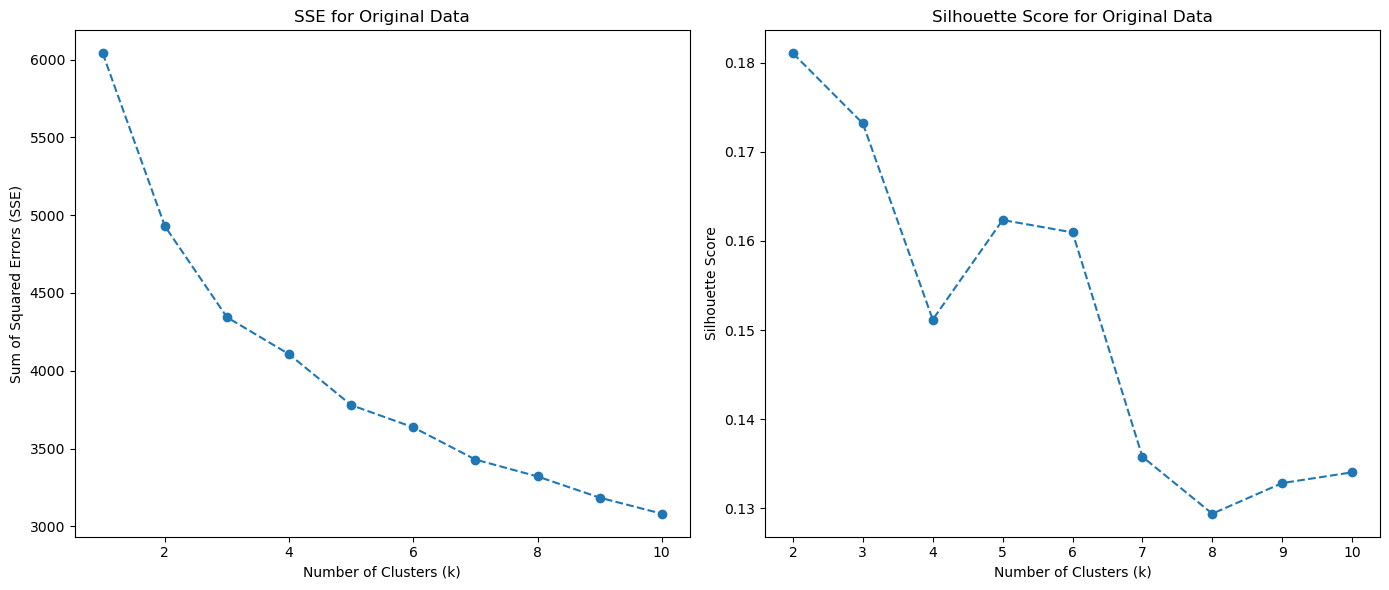

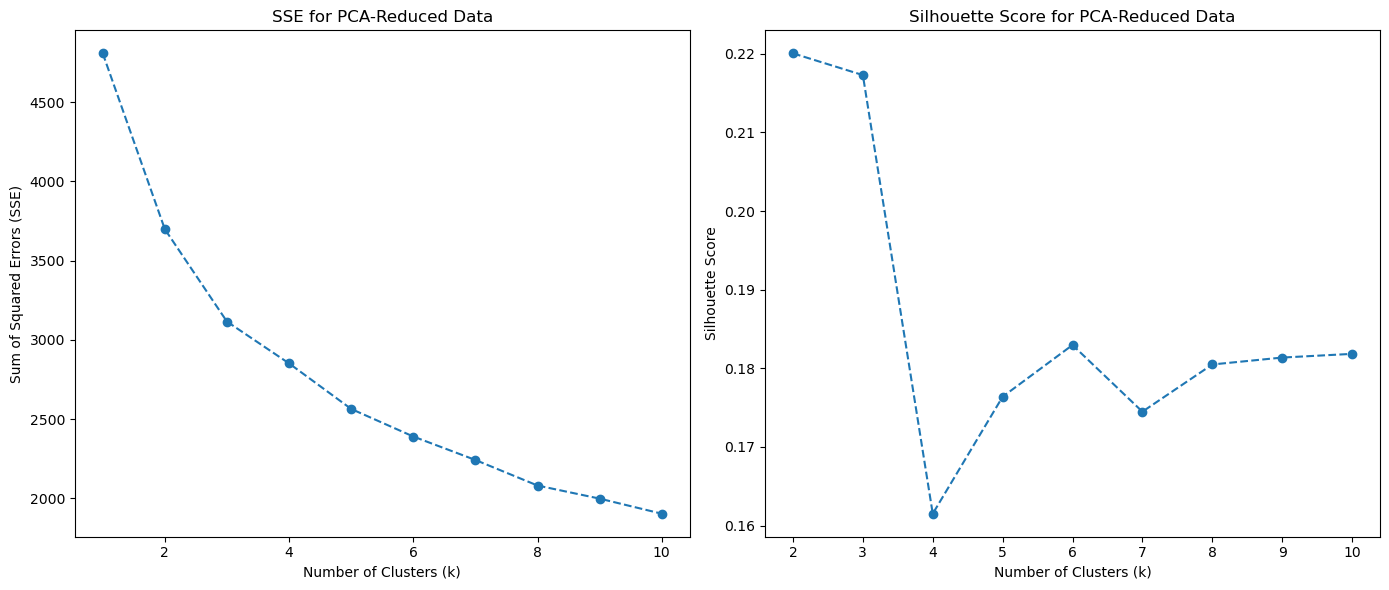

Optimal number of clusters for original data (SSE): 1
Optimal number of clusters for original data (Silhouette): 2
Optimal number of clusters for PCA-reduced data (SSE): 1
Optimal number of clusters for PCA-reduced data (Silhouette): 2


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Standardize the input variables
scaler = StandardScaler()
df[input_vars] = scaler.fit_transform(df[input_vars])

# Perform PCA
pca = PCA(n_components=num_pcs)
df_pca = pca.fit_transform(df[input_vars])

# Function to perform K-Means clustering and calculate SSE and Silhouette Score
def kmeans_clustering(data, max_k=10):
    sse = []
    silhouette_scores = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)  # Silhouette score is not defined for k=1
    return sse, silhouette_scores

# Perform K-Means clustering on original data
sse_original, silhouette_scores_original = kmeans_clustering(df[input_vars])

# Perform K-Means clustering on PCA-reduced data
sse_pca, silhouette_scores_pca = kmeans_clustering(df_pca)

# Plot SSE and Silhouette Score for original data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), sse_original, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE for Original Data')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_original[1:], marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Original Data')

plt.tight_layout()
plt.show()

# Plot SSE and Silhouette Score for PCA-reduced data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), sse_pca, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE for PCA-Reduced Data')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_pca[1:], marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for PCA-Reduced Data')

plt.tight_layout()
plt.show()

# Determine the optimal number of clusters using the Elbow Method
optimal_k_sse_original = np.argmax(np.diff(sse_original) < 0) + 1
optimal_k_sse_pca = np.argmax(np.diff(sse_pca) < 0) + 1

optimal_k_silhouette_original = np.argmax(silhouette_scores_original[1:]) + 2
optimal_k_silhouette_pca = np.argmax(silhouette_scores_pca[1:]) + 2

print(f'Optimal number of clusters for original data (SSE): {optimal_k_sse_original}')
print(f'Optimal number of clusters for original data (Silhouette): {optimal_k_silhouette_original}')
print(f'Optimal number of clusters for PCA-reduced data (SSE): {optimal_k_sse_pca}')
print(f'Optimal number of clusters for PCA-reduced data (Silhouette): {optimal_k_silhouette_pca}')

In [13]:
# Perform K-Means clustering with the optimal number of clusters
kmeans_original = KMeans(n_clusters=optimal_k_silhouette_original, random_state=42)
df['Cluster_Original'] = kmeans_original.fit_predict(df[input_vars])

kmeans_pca = KMeans(n_clusters=optimal_k_silhouette_pca, random_state=42)
df['Cluster_PCA'] = kmeans_pca.fit_predict(df_pca)

# Descriptive overview of the clusters
print("Descriptive Overview of Clusters (Original Data):")
print(df.groupby('Cluster_Original').mean())

print("\nDescriptive Overview of Clusters (PCA-Reduced Data):")
print(df.groupby('Cluster_PCA').mean())

Descriptive Overview of Clusters (Original Data):
                  Pregnancies   Glucose  BloodPressure  SkinThickness  \
Cluster_Original                                                        
0                    0.530093  0.483383       0.516765       0.382781   
1                   -0.498751 -0.454802      -0.486211      -0.360149   

                   Insulin       BMI  DiabetesPedigreeFunction       Age  \
Cluster_Original                                                           
0                 0.285176  0.394341                  0.125129  0.618647   
1                -0.268315 -0.371025                 -0.117730 -0.582069   

                   Outcome  Cluster_PCA  
Cluster_Original                         
0                 0.546448     0.005464  
1                 0.164524     1.000000  

Descriptive Overview of Clusters (PCA-Reduced Data):
             Pregnancies   Glucose  BloodPressure  SkinThickness  Insulin  \
Cluster_PCA                                          

In [14]:
# Compare clusters with the outcome
print("\nCluster Alignment with Outcome (Original Data):")
print(pd.crosstab(df['Cluster_Original'], df['Outcome']))

print("\nCluster Alignment with Outcome (PCA-Reduced Data):")
print(pd.crosstab(df['Cluster_PCA'], df['Outcome']))


Cluster Alignment with Outcome (Original Data):
Outcome             0    1
Cluster_Original          
0                 166  200
1                 325   64

Cluster Alignment with Outcome (PCA-Reduced Data):
Outcome        0    1
Cluster_PCA          
0            164  200
1            327   64


#### Task Kohonen Self-Organizing Maps

Perform the following tasks for the original (but normalized) variables.
1) Train a SOM on the input variables.
2) Visualize the SOM using U-matrix and highlighting the neighbourhood distance. Calculate the Quantization Error (average Euclidean of each data point and its BMU).
3) Vary the SOM parameters. How do changes in grid size,  learning rate, sigma (spread of the neighbourhood function) and topology affect the U-matrix/Quantization Error? Which parameters do you see as the best fit for the data?
4) Based on your preferred parameters, Label the data points by the cluster assignment of their BMU.
5) Compare if the clusters align with the outcome.
6) Compare if the clusters align with the two versions of clusters (original data & dimensionality-reduced data) created by K-Means Clustering.

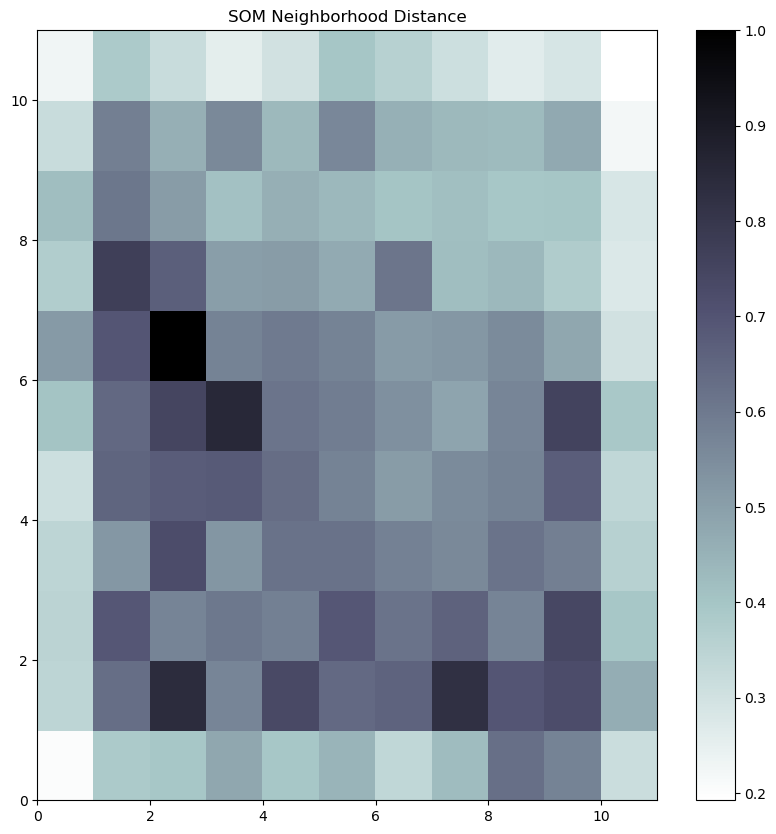

Quantization Error: 1.2815126512200843


In [17]:
from minisom import MiniSom

# Initialize the SOM
som_size = 11  # 11x11 map structure
som = MiniSom(som_size, som_size, len(input_vars), sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)

# Train the SOM on 1000 iterations
som.train_random(df[input_vars].values, 1000)

# Plot the neighborhood distance of the trained SOM
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('SOM Neighborhood Distance')
plt.show()

# Calculate the Quantization Error
quantization_error = np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in df[input_vars].values])
print(f'Quantization Error: {quantization_error}')

In [18]:
# Function to train SOM with different parameters and calculate Quantization Error
def train_som_and_calculate_error(som_size, sigma, learning_rate):
    som = MiniSom(som_size, som_size, len(input_vars), sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian', random_seed=42)
    som.train_random(df[input_vars].values, 1000)
    quantization_error = np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in df[input_vars].values])
    return quantization_error

# Test different parameters
parameters = [
    (11, 1.0, 0.5),
    (15, 1.0, 0.5),
    (11, 0.5, 0.5),
    (11, 1.0, 0.1),
    (11, 1.0, 0.9)
]

for som_size, sigma, learning_rate in parameters:
    error = train_som_and_calculate_error(som_size, sigma, learning_rate)
    print(f'SOM Size: {som_size}x{som_size}, Sigma: {sigma}, Learning Rate: {learning_rate}, Quantization Error: {error}')

SOM Size: 11x11, Sigma: 1.0, Learning Rate: 0.5, Quantization Error: 1.2815126512200843
SOM Size: 15x15, Sigma: 1.0, Learning Rate: 0.5, Quantization Error: 1.176009851943827
SOM Size: 11x11, Sigma: 0.5, Learning Rate: 0.5, Quantization Error: 1.318831335671194
SOM Size: 11x11, Sigma: 1.0, Learning Rate: 0.1, Quantization Error: 1.548730696324809
SOM Size: 11x11, Sigma: 1.0, Learning Rate: 0.9, Quantization Error: 1.2560693590007193


In [ ]:
# Use the preferred parameters (e.g., 11x11, sigma=1.0, learning_rate=0.5)
som = MiniSom(11, 11, len(input_vars), sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
som.train_random(df[input_vars].values, 1000)

# Assign each data point to its BMU's cluster label
bmu_indices = np.array([som.winner(x) for x in df[input_vars].values])
bmu_indices_flat = np.ravel_multi_index(bmu_indices.T, (11, 11))
df['Cluster_SOM'] = bmu_indices_flat

# Compare clusters with the outcome
print("Cluster Alignment with Outcome (SOM):")
print(pd.crosstab(df['Cluster_SOM'], df['Outcome']))

Cluster Alignment with Outcome (SOM):
Outcome       0  1
Cluster_SOM       
0             4  1
1             3  1
2             2  2
3             4  2
4             7  1
...          .. ..
116           3  1
117          10  1
118           9  0
119           7  0
120           9  1

[121 rows x 2 columns]


In [21]:
# Compare clusters with the original and PCA-reduced K-Means clusters
print("Cluster Alignment with Original K-Means Clusters:")
print(pd.crosstab(df['Cluster_SOM'], df['Cluster_Original']))

print("\nCluster Alignment with PCA-Reduced K-Means Clusters:")
print(pd.crosstab(df['Cluster_SOM'], df['Cluster_PCA']))

Cluster Alignment with Original K-Means Clusters:
Cluster_Original  0   1
Cluster_SOM            
0                 3   2
1                 4   0
2                 2   2
3                 3   3
4                 3   5
...              ..  ..
116               1   3
117               0  11
118               0   9
119               0   7
120               0  10

[121 rows x 2 columns]

Cluster Alignment with PCA-Reduced K-Means Clusters:
Cluster_PCA  0   1
Cluster_SOM       
0            3   2
1            4   0
2            2   2
3            3   3
4            2   6
...         ..  ..
116          1   3
117          0  11
118          0   9
119          0   7
120          0  10

[121 rows x 2 columns]
